<h1 style="text-align:center;font-size:40px;" > Implementing Segmentation Architectures </h1>

# 1.0 Basic U-NET (First-cut approach)

![alt text](https://drive.google.com/uc?id=1eS1GuAldhs-KYK-RQ6lKO7jTyGgm3hcN)

**References-**
- https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [0]:
def get_unet(input_img, n_filters, dropout, batchnorm):
    
    """Function to define the UNET architecture"""
    
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(4, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [0]:
input_img = Input((128, 800, 3), name='img')
model = get_unet(input_img, n_filters=8, dropout=0.2, batchnorm=True)
model.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=[dice_coef])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 800, 3)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 800, 8)  224         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 128, 800, 8)  32          conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 128, 800, 8)  0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

## 1.1 Checkpointing the model and creating the callback list

In [0]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
import matplotlib.pyplot as plt
from tensorflow.python.keras.callbacks import TensorBoard
from keras.callbacks import TensorBoard
import tensorflow as tf
import datetime
import keras
from tensorboardcolab import *
from keras.callbacks import ReduceLROnPlateau

#https://github.com/taomanwai/tensorboardcolab/
tbc=TensorBoardColab()
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
mc = ModelCheckpoint('best_model_unet.h5', monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')
callbacks_list = [mc, TensorBoardColabCallback(tbc)]

Wait for 8 seconds...
TensorBoard link:
https://bde24643.ngrok.io


## 1.2 Fitting the train data and validation

In [0]:
train_batches = Train_DataGenerator(train_data,shuffle=True)
valid_batches = Val_DataGenerator(cv_data)
history = model.fit_generator(train_batches, validation_data = valid_batches, epochs = 50, verbose=1,
                              class_weight= class_wts,callbacks= callbacks_list) #class_wts as clculated in EDA





Epoch 1/50
667/667 [==============================] - 235s 352ms/step - loss: 1.2888 - dice_coef: 0.0286 - val_loss: 0.9921 - val_dice_coef: 0.0688

Epoch 00001: val_dice_coef improved from -inf to 0.06879, saving model to /content/weights.best.hdf5

Epoch 2/50
667/667 [==============================] - 221s 332ms/step - loss: 0.7664 - dice_coef: 0.2798 - val_loss: 0.6661 - val_dice_coef: 0.3743

Epoch 00002: val_dice_coef improved from 0.06879 to 0.37426, saving model to /content/weights.best.hdf5
Epoch 3/50
667/667 [==============================] - 218s 327ms/step - loss: 0.6021 - dice_coef: 0.4394 - val_loss: 0.6355 - val_dice_coef: 0.4068

Epoch 00003: val_dice_coef improved from 0.37426 to 0.40684, saving model to /content/weights.best.hdf5
Epoch 4/50
667/667 [==============================] - 218s 327ms/step - loss: 0.5688 - dice_coef: 0.4727 - val_loss: 0.5948 - val_dice_coef: 0.4483

Epoch 00004: val_dice_coef improved from 0.40684 to 0.44832, saving model to /content/weig

## 1.3 Plots on training & validation results

### Loss function & metric plots

**Please refer to Training Plots in utility functions section.**

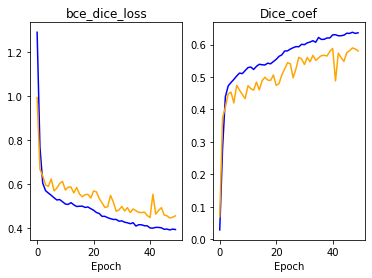

In [0]:
plot(history)

### Tensorboard images

![img](https://drive.google.com/uc?id=1c_g5vl3EzaAOp9Ll4BhaXDZ7wFO1_3ut)

![alt text](https://drive.google.com/uc?id=1zsbpaKzNvuz8QgnU9DhjAuYBG0F9-zd8)

![alt text](https://drive.google.com/uc?id=1s2LjMtm_QtRcfMQ4yVPTkOZuSKTMw-mJ)

## 1.4 Model Testing

### Loading the best model for evaluation

In [0]:
from keras.models import load_model
dependencies = {'bce_dice_loss':bce_dice_loss,'dice_coef':dice_coef,}
model_best = load_model('/content/best_model_unet.h5',custom_objects=dependencies)

### Evaluating on validation images

In [0]:
evals= model_best.evaluate(valid_batches,verbose=1)

117/117 [==============================] - 36s 306ms/step


In [0]:
print('Validation set evaluation score:')
print('bce_dice loss:',evals[0])
print('dice_coeff:',evals[1])

Validation set evaluation score:
bce_dice loss: 0.4407530933873266
dice_coeff: 0.5941144448314977


## 1.5 Defects visualization

**Please refer to the "visualize_defects" function in Utility functions section.**

### Training set

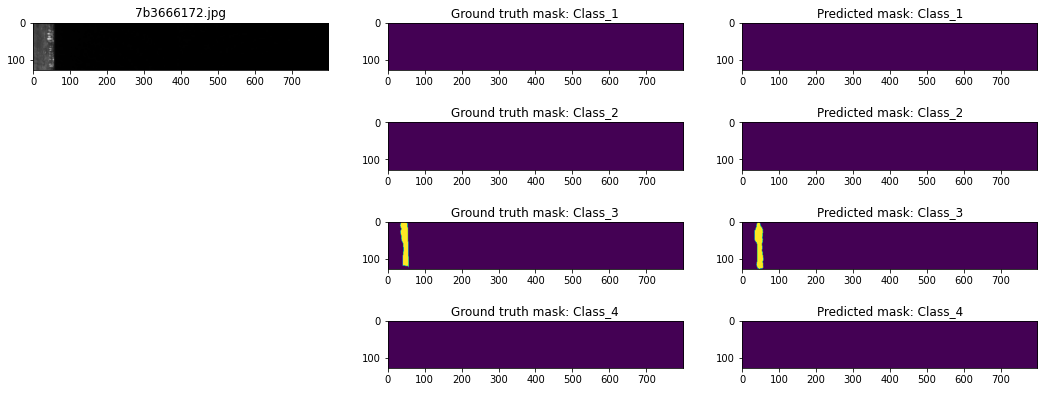

----------------------------------------------------------------------------------------------------


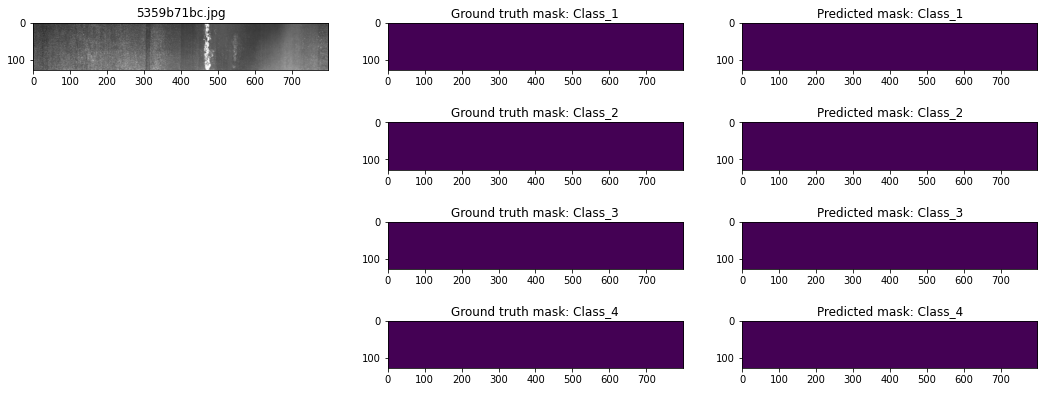

----------------------------------------------------------------------------------------------------


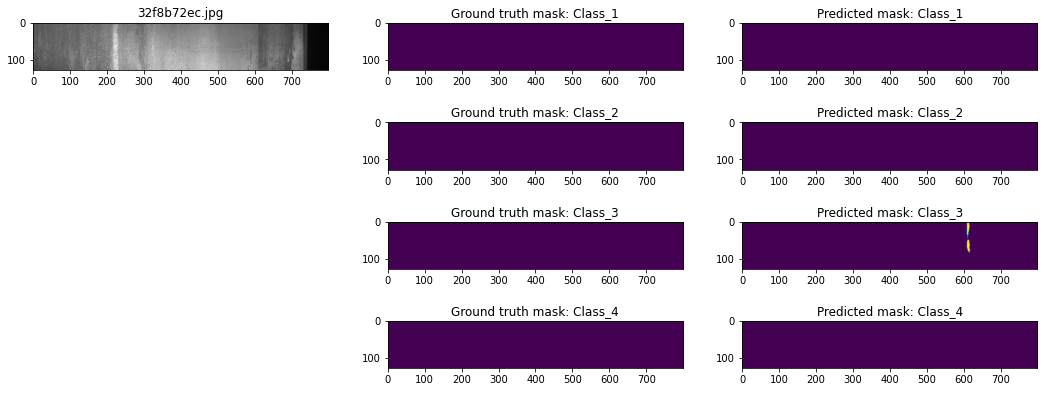

----------------------------------------------------------------------------------------------------


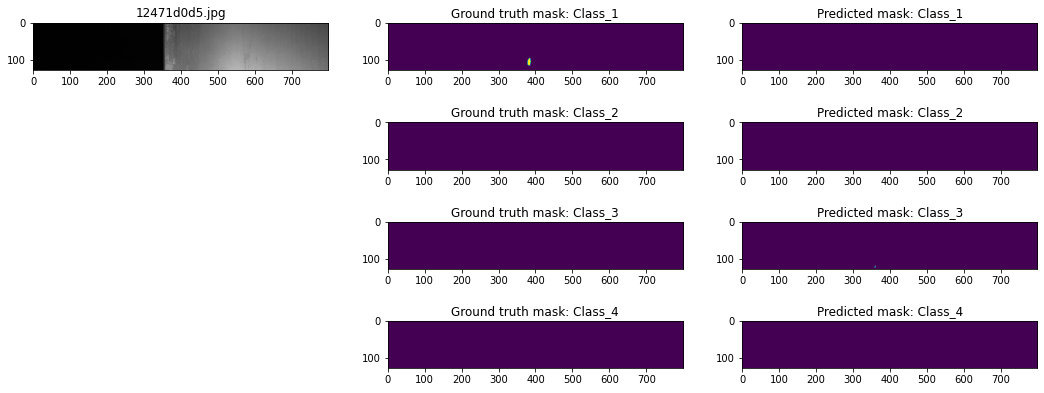

----------------------------------------------------------------------------------------------------


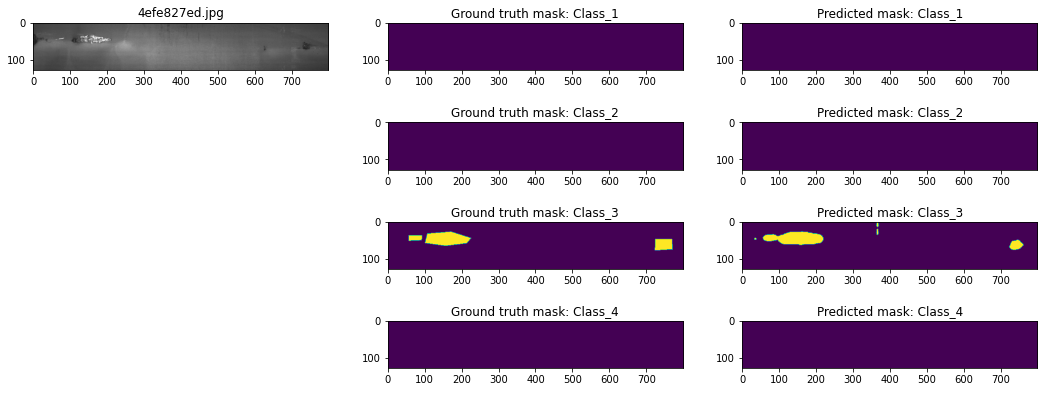

----------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(train_data,model_best)

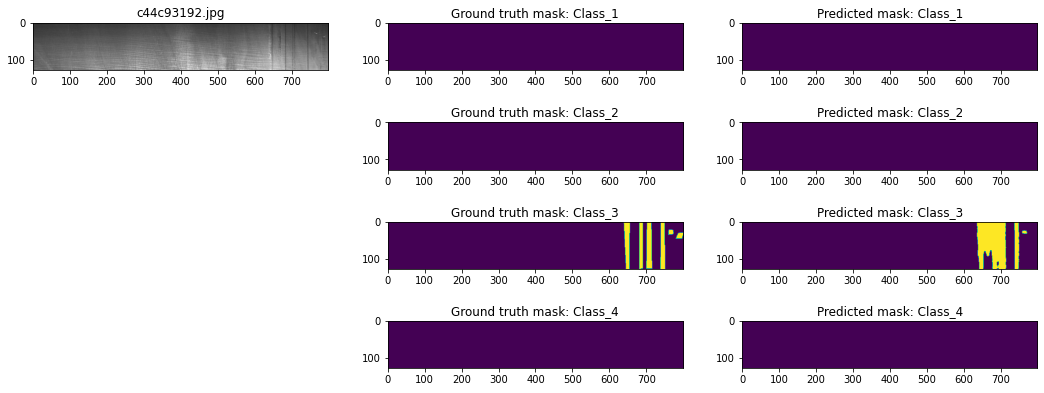

----------------------------------------------------------------------------------------------------


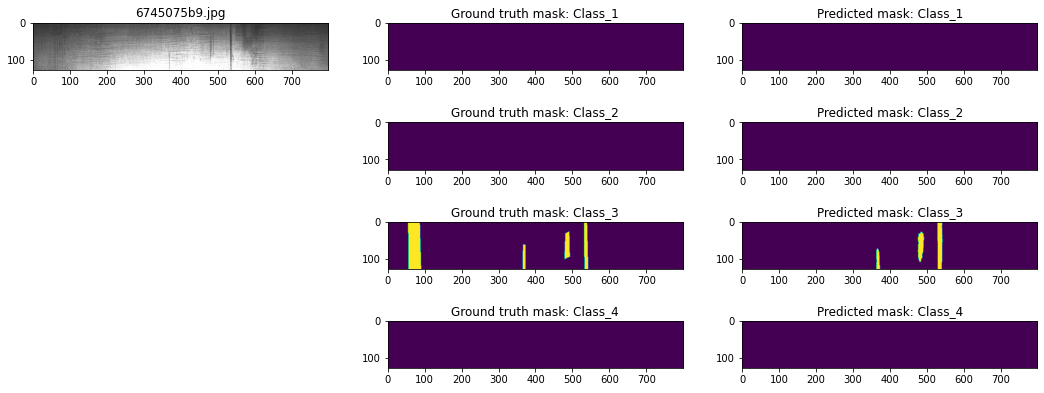

----------------------------------------------------------------------------------------------------


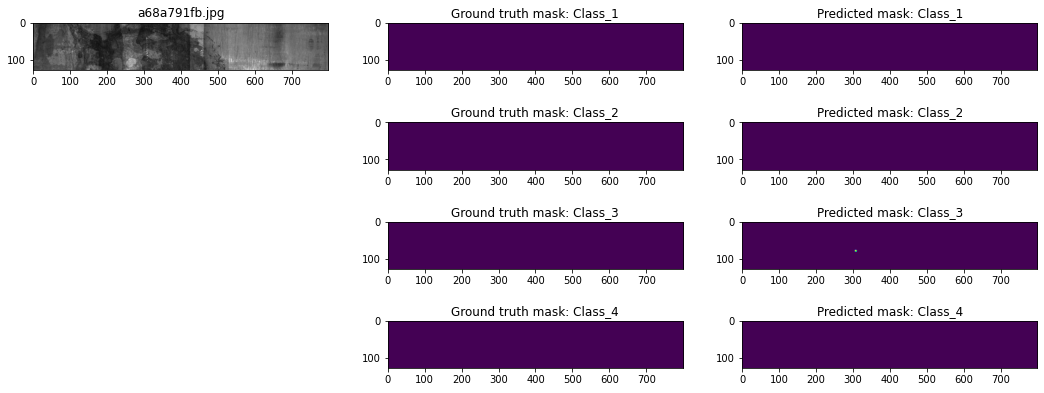

----------------------------------------------------------------------------------------------------


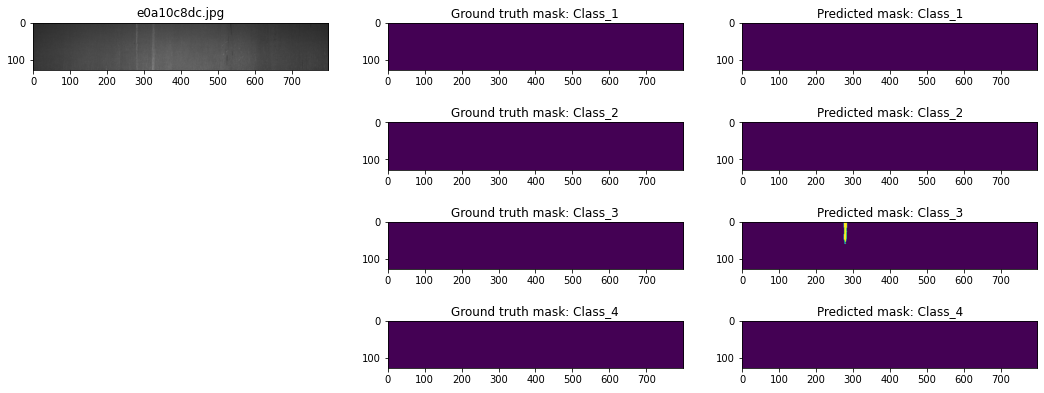

----------------------------------------------------------------------------------------------------


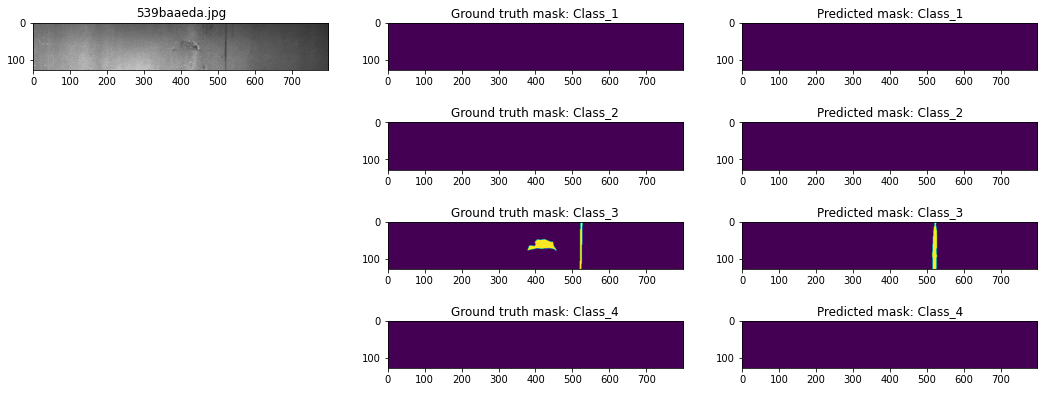

----------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(train_data,model_best)

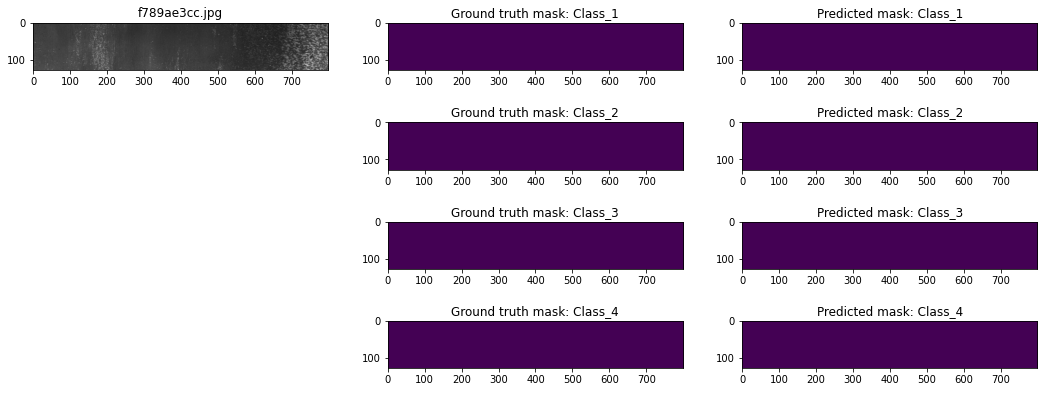

----------------------------------------------------------------------------------------------------


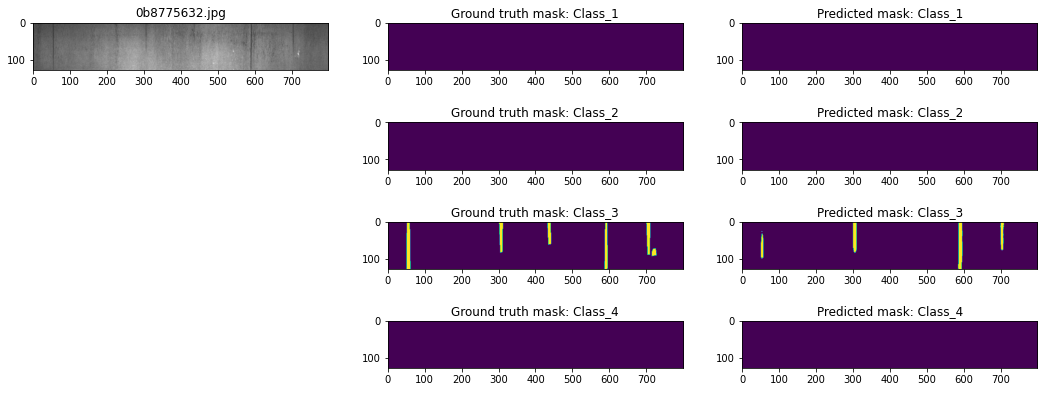

----------------------------------------------------------------------------------------------------


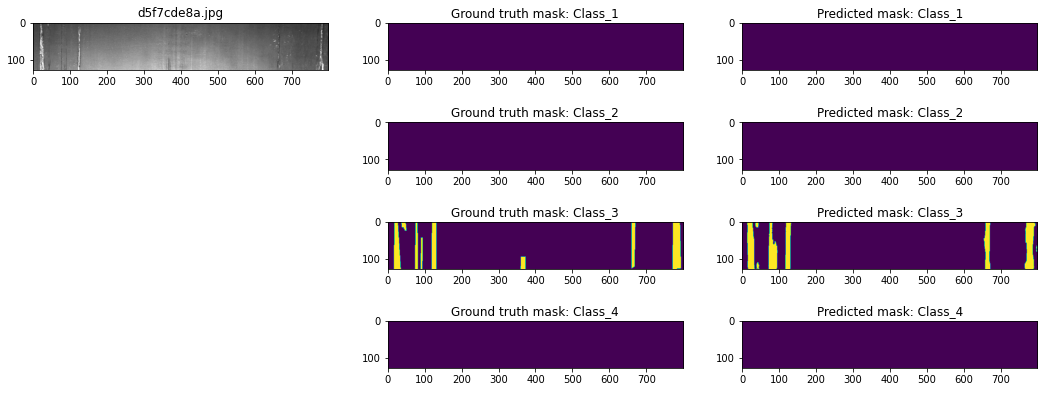

----------------------------------------------------------------------------------------------------


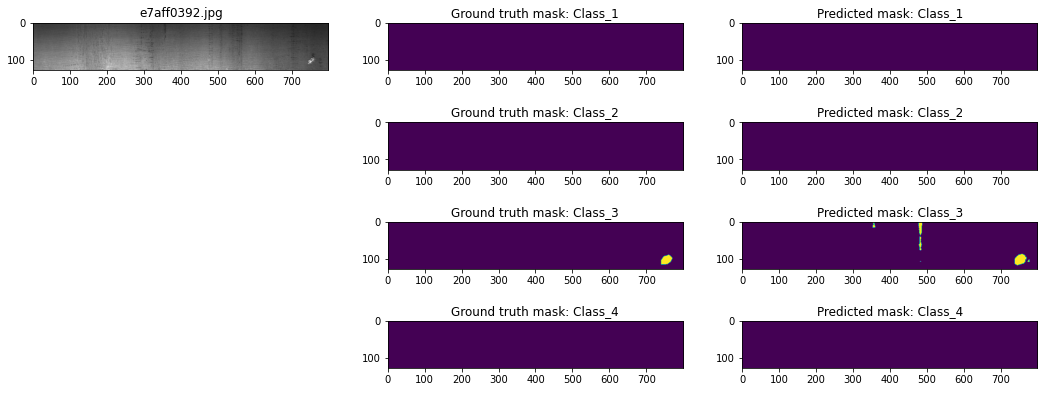

----------------------------------------------------------------------------------------------------


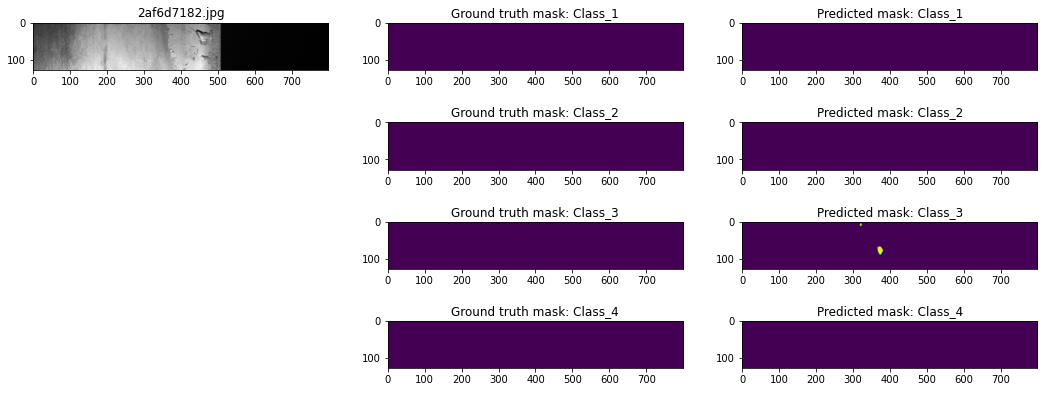

----------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(train_data,model_best)

### Validation set

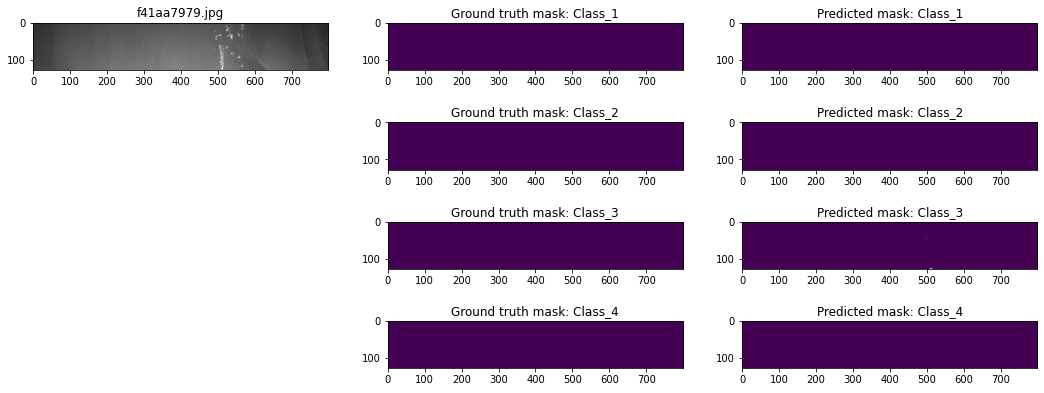

----------------------------------------------------------------------------------------------------


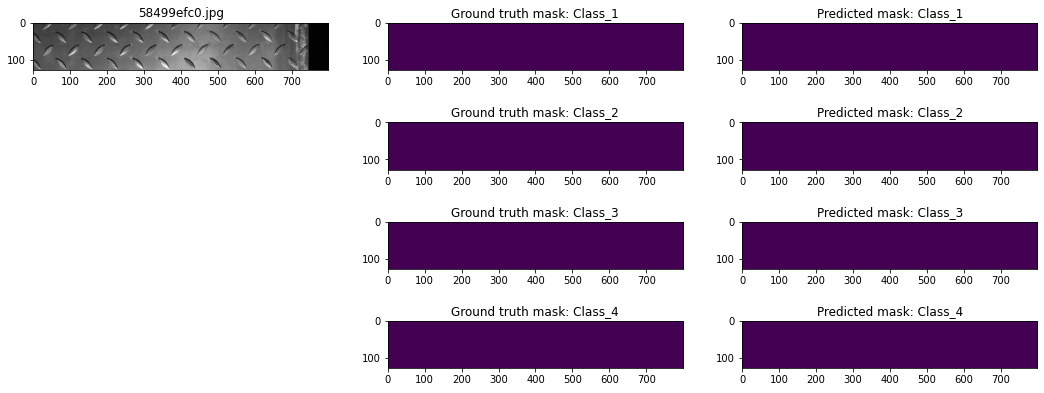

----------------------------------------------------------------------------------------------------


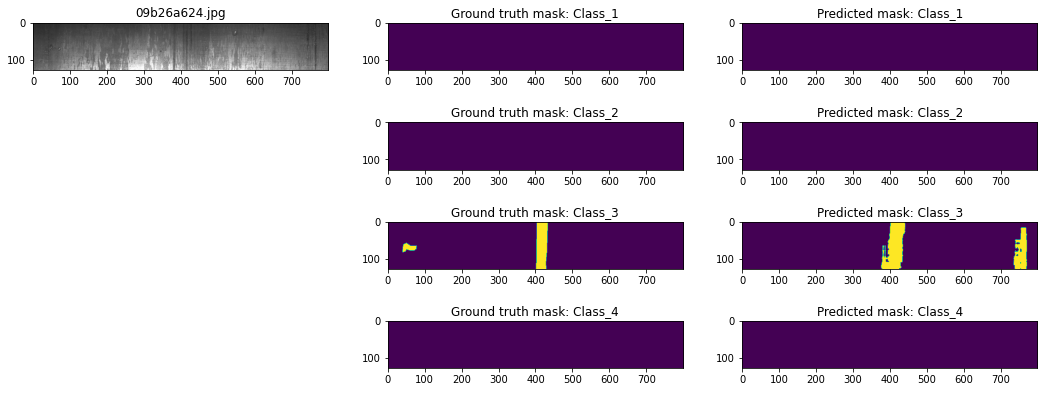

----------------------------------------------------------------------------------------------------


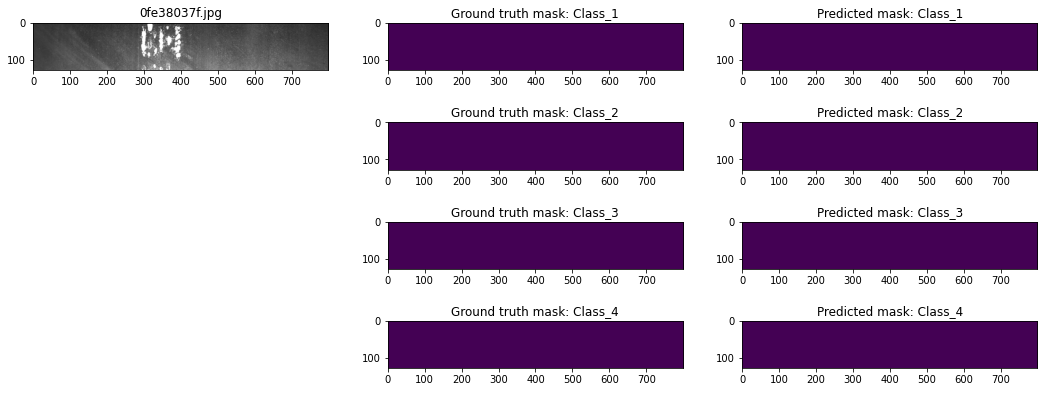

----------------------------------------------------------------------------------------------------


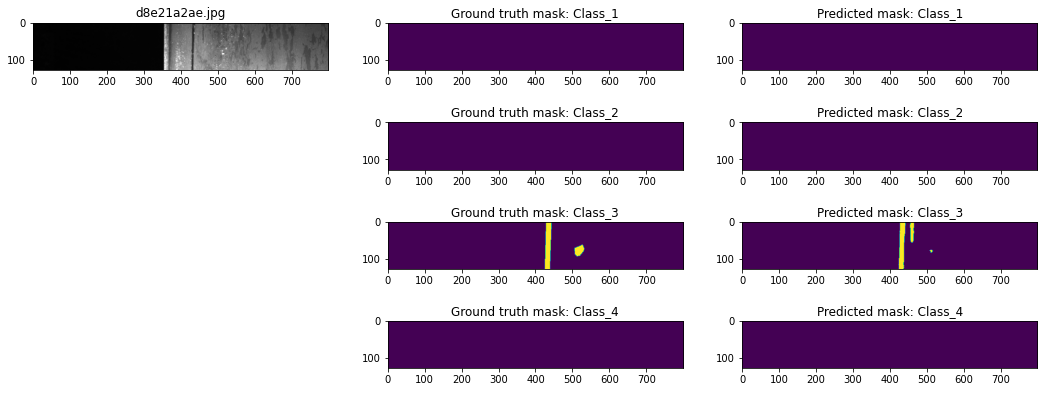

----------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(cv_data,model_best)

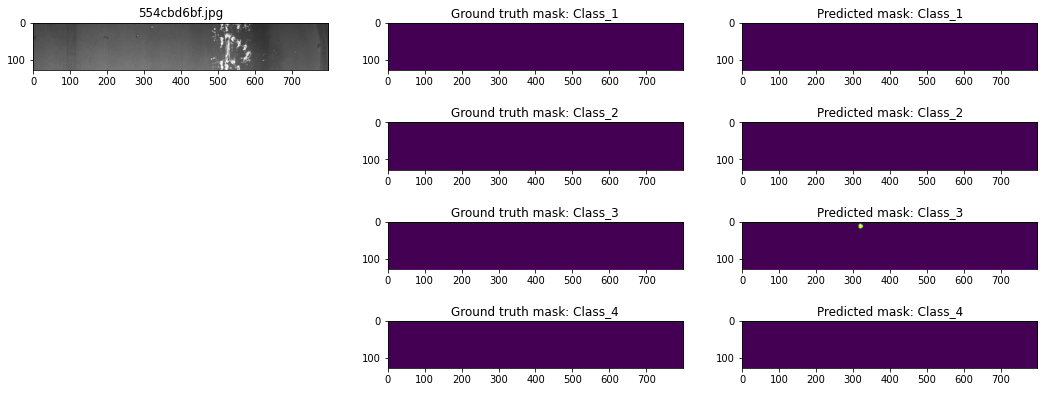

----------------------------------------------------------------------------------------------------


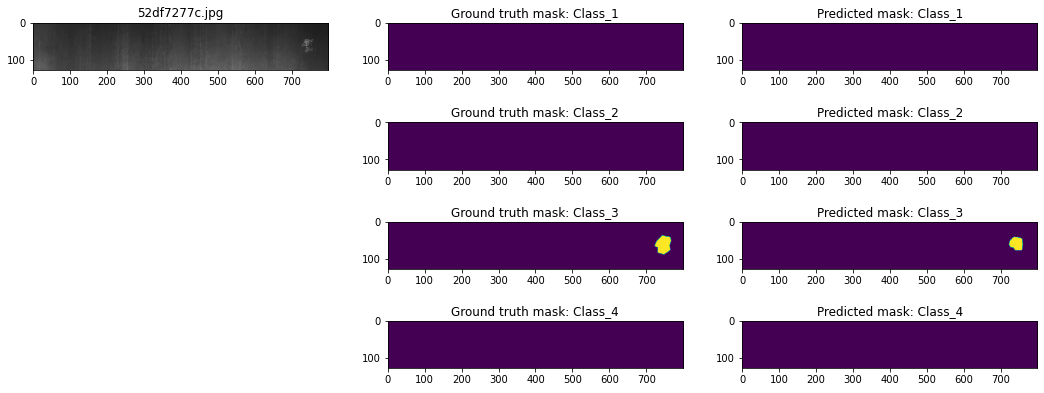

----------------------------------------------------------------------------------------------------


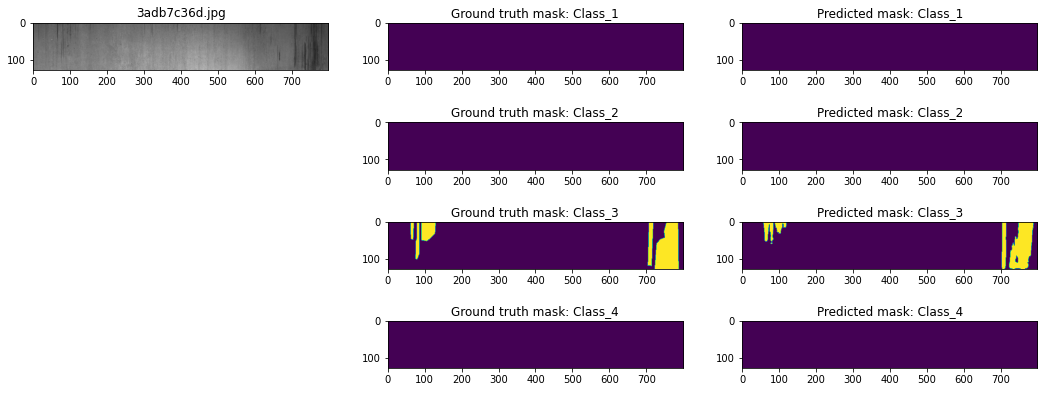

----------------------------------------------------------------------------------------------------


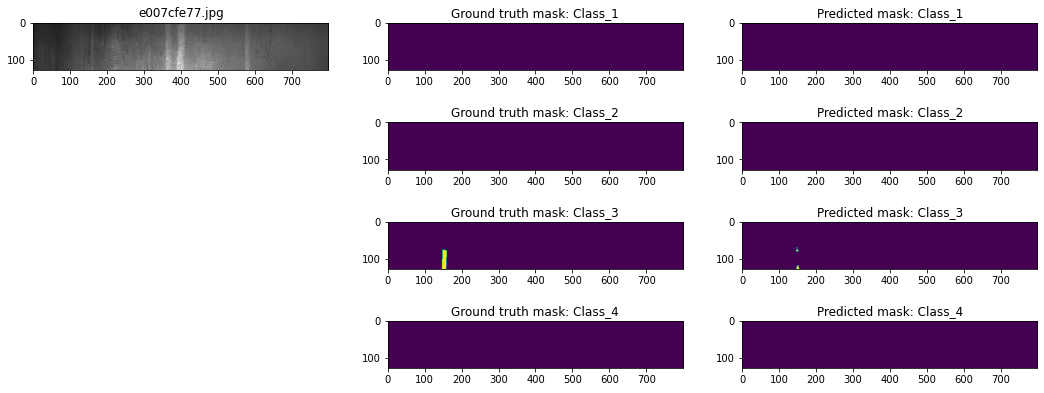

----------------------------------------------------------------------------------------------------


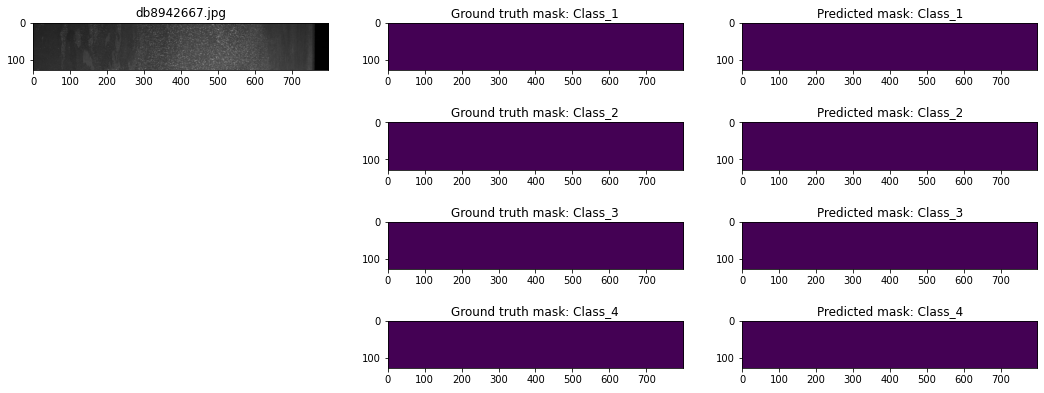

----------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(cv_data,model_best)

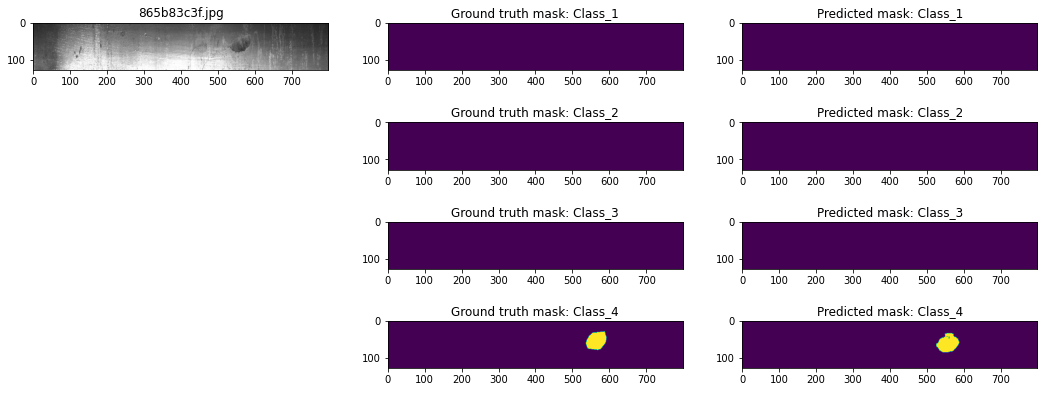

----------------------------------------------------------------------------------------------------


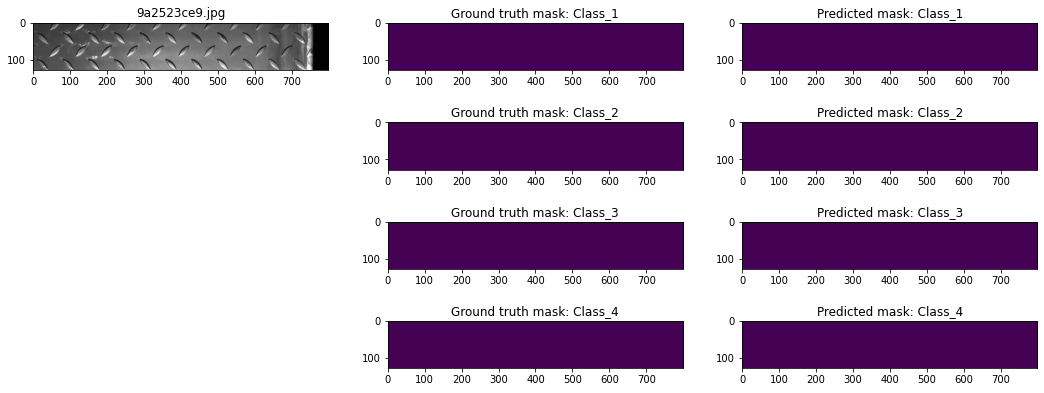

----------------------------------------------------------------------------------------------------


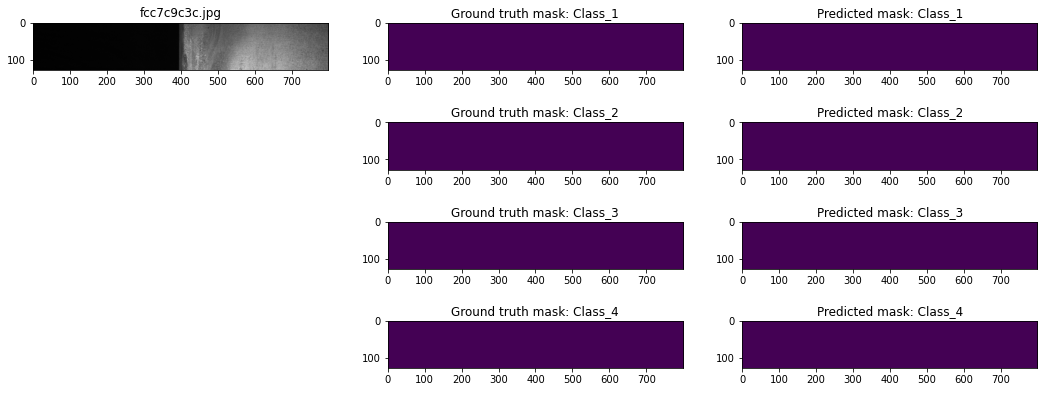

----------------------------------------------------------------------------------------------------


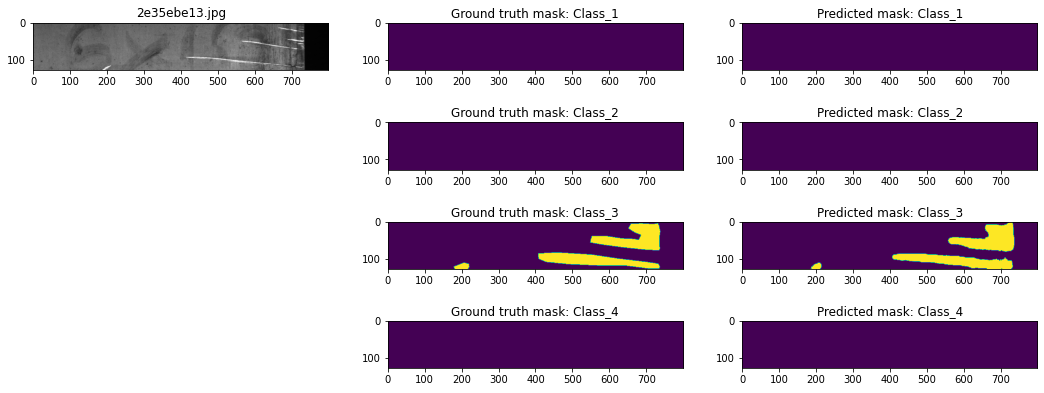

----------------------------------------------------------------------------------------------------


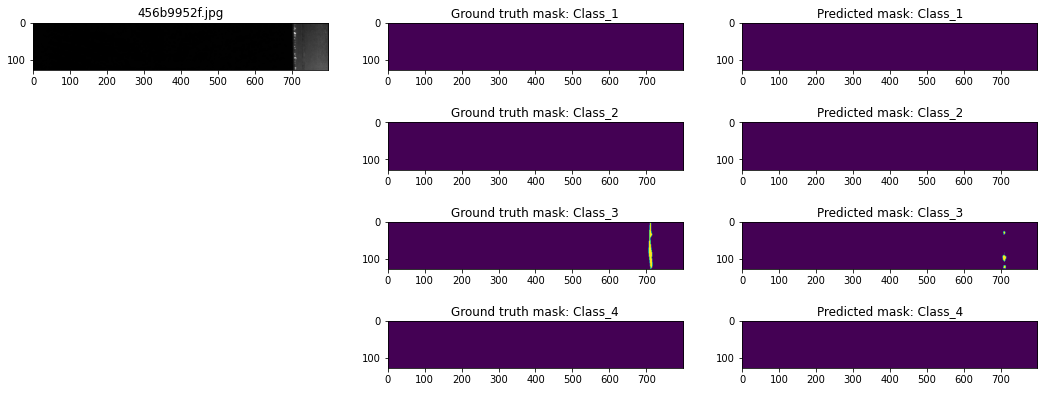

----------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(cv_data,model_best)

## 1.6 Predicting defects on raw test images

### Predicting on raw test images by resizing images to 128x800 dimensions in order to apply the model

In [0]:
# Predicting on test images
from tqdm import tqdm
import cv2
data_path = '/content/' + 'test_images/'
files = list(os.listdir(data_path))
rle_lst = [] #list to store defect in run length encoding format
img_classId= [] #list to store Image ID + classId
for f in tqdm(files):
    X = np.empty((1,128,800,3),dtype=np.float32)
    img = cv2.imread(data_path + f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (800,128))
    X[0,] = img
    mask = model_best.predict(X)
    rle_m = np.empty((128,800),dtype=np.uint8)
    for i in range(4):
        rle_m = mask[0,:,:,i].round().astype(int)
        rle = mask2rle(rle_m)
        rle_lst.append(rle)
        img_classId.append(f+'_'+str(i+1))

100%|██████████| 5506/5506 [01:29<00:00, 61.81it/s]


In [0]:
output = {'ImageId_ClassId':img_classId, 'EncodedPixels' : rle_lst}
import pandas as pd
output_df = pd.DataFrame(output)
output_df.to_csv('submission_unet_128X800.csv', index=False)

**With this submission in kaggle, I got a private dice coefficient score of 0.79814 & a public score of 0.78045.**

### Redefining the unet architecture for original image size of 256x1600

In [0]:
input_img = Input((256,1600,3), name='img')
model = get_unet(input_img, n_filters=8, dropout=0.2, batchnorm=True)
model.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=[dice_coef])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 1600, 3) 0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 1600, 8) 224         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 256, 1600, 8) 32          conv2d_39[0][0]                  
__________________________________________________________________________________________________
activation_37 (Activation)      (None, 256, 1600, 8) 0           batch_normalization_37[0][0]     
____________________________________________________________________________________________

In [0]:
model.set_weights(model_best.get_weights()) #transfering the weights of 128x800 model

### Predicting on full 256x1600 raw test images

In [0]:
# Predicting on test images
from tqdm import tqdm
import cv2
data_path = '/content/' + 'test_images/'
files = list(os.listdir(data_path))
rle_lst = [] #list to store defect in run length encoding format
img_classId= [] #list to store Image ID + classId

for f in tqdm(files):
    X = np.empty((1,256,1600,3),dtype=np.float32)
    img = cv2.imread(data_path + f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X[0,] = img
    mask = model.predict(X)
    rle_m = np.empty((256,1600),dtype=np.uint8)
    for i in range(4):
        rle_m = mask[0,:,:,i].round().astype(int)
        rle = mask2rle(rle_m)
        rle_lst.append(rle)
        img_classId.append(f+'_'+str(i+1))

100%|██████████| 5506/5506 [04:12<00:00, 21.80it/s]


In [0]:
output = {'ImageId_ClassId':img_classId, 'EncodedPixels' : rle_lst}
import pandas as pd
output_df = pd.DataFrame(output)
output_df.to_csv('submission_unet_256_1600.csv', index=False)

**With this submission, I got a private dice coefficient score of 0.81171 & a public score of 0.80041.**

- This task of predicting on full images was inspired from this kernel: https://www.kaggle.com/c/severstal-steel-defect-detection/discussion/114321
- The author of the kernel had proof of better scores when defects were predicted on 256x1600 instead of 128x800
- This strategy worked out for me as I got a higher score when predicted on full images compared to half images
- **Henceforth, for other architectures, I will be predicting on 256x1800 images instead of 128x800**

## 1.7 Visualizing defects of raw test images(256x1600)

**Please refer to the "visualize_defects_test" function in Utility functions section.**

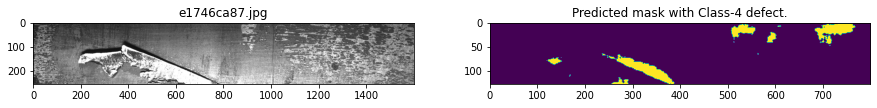

------------------------------------------------------------------------------------------------------------------------------------------------------


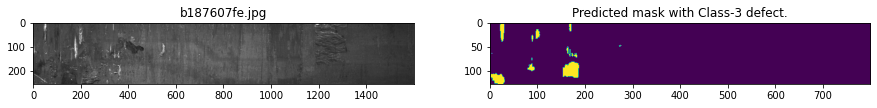

------------------------------------------------------------------------------------------------------------------------------------------------------


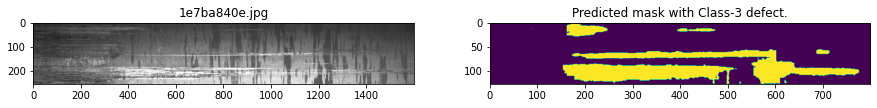

------------------------------------------------------------------------------------------------------------------------------------------------------


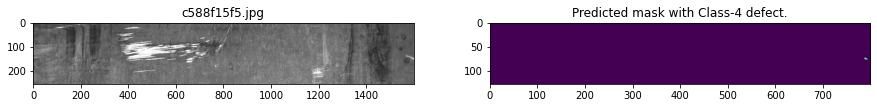

------------------------------------------------------------------------------------------------------------------------------------------------------


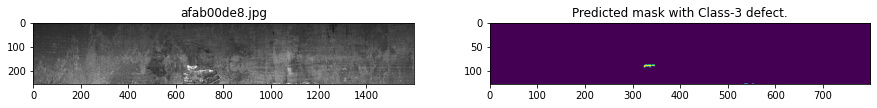

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects_test(output_df,5)

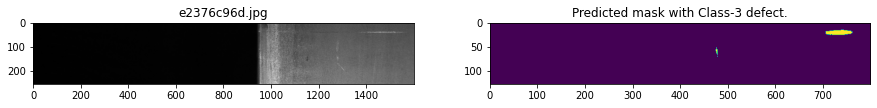

------------------------------------------------------------------------------------------------------------------------------------------------------


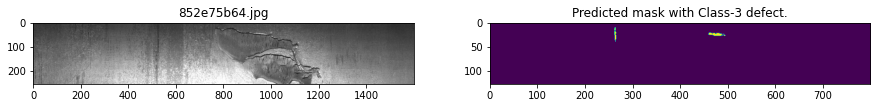

------------------------------------------------------------------------------------------------------------------------------------------------------


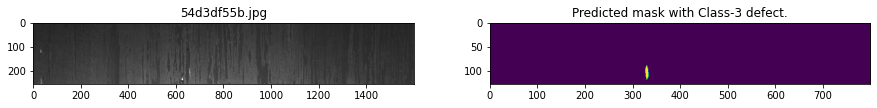

------------------------------------------------------------------------------------------------------------------------------------------------------


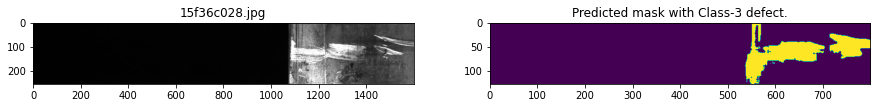

------------------------------------------------------------------------------------------------------------------------------------------------------


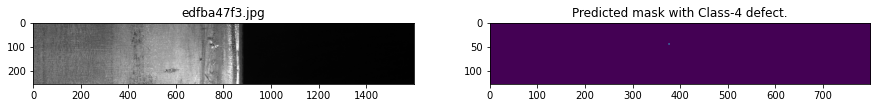

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects_test(output_df,5)

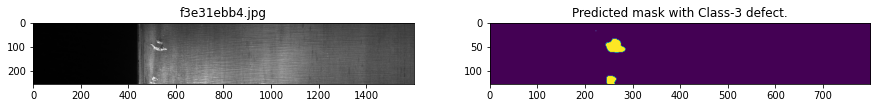

------------------------------------------------------------------------------------------------------------------------------------------------------


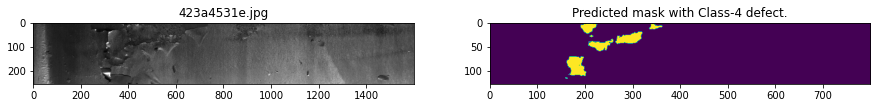

------------------------------------------------------------------------------------------------------------------------------------------------------


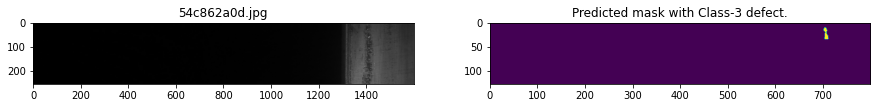

------------------------------------------------------------------------------------------------------------------------------------------------------


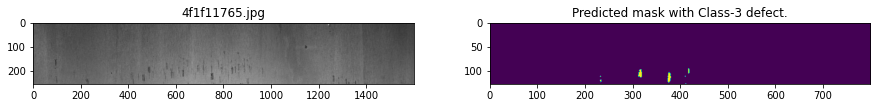

------------------------------------------------------------------------------------------------------------------------------------------------------


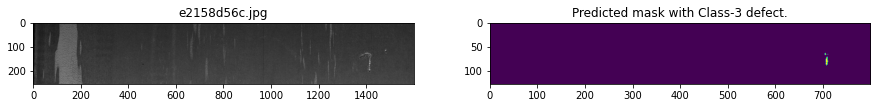

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects_test(output_df,5)